In [39]:
import pandas as pd
import plotly_express as px
import humanize as hu

In [64]:
#reading the csv file
df = pd.read_csv("flood_control_data.csv", sep=",")

In [ ]:
df["ABC"]

In [ ]:
#retrieving the min and max of the infra year
df

In [ ]:
#retrieve all region
df[df["Region"] == "Region I"]["Province"].unique()

In [ ]:
#get the total alocated funds default
df["StartDate"] = pd.to_datetime(df["StartDate"], format="%d/%m/%Y")

In [ ]:
#get the timeseries projects by month of the year
df["monthyear"] = df["StartDate"].apply(lambda araw: str(araw.month) + str(araw.year))

In [ ]:
df.groupby("monthyear")

In [ ]:
df["ProjectID"].nunique()

In [ ]:
df[df["ProjectID"].duplicated()]

In [ ]:
df[df["ProjectID"] == "P00421352LZ"].reset_index(drop=True)

In [ ]:
import plotly_express as px

In [ ]:
#generating the number of projects over time
dat = df.groupby("StartDate").agg({
    "ProjectID": "count",
    "ABC": "sum"
}).reset_index().rename(columns={"ProjectID": "Total Projects", "ABC":"Total Spent"})


In [ ]:
fig = px.line(dat, x="StartDate", y="Total Projects")
fig.update_layout(
    plot_bgcolor="white",
    paper_bgcolor="white"
)
fig.show()

In [ ]:
#how many projects started per quarter
df["quarter"] = df["StartDate"].dt.quarter

In [ ]:
qua = df.groupby("quarter")["ProjectID"].nunique().reset_index(name="total projects")

In [ ]:
fig2 = px.pie(qua, names="quarter", values="total projects")
fig2.show()

In [ ]:
import dash
from dash import html
import dash_cytoscape as cyto
import pandas as pd

# Sample of your dataset
data = {
    "ProjectID": ["P00824759LZ", "P00824758LZ", "P00824750LZ"],
    "ProjectDescription": [
        "Babuyan River Flood Control Downstream",
        "Langogan River Flood Control",
        "Babuyan River Flood Control Upstream"
    ],
    "Contractor": ["AZARRAGA CONSTRUCTION", "AZARRAGA CONSTRUCTION", "F.F. GALANG CONSTRUCTION"]
}
df = pd.DataFrame(data)

# Build Cytoscape elements
elements = []

# Add contractor nodes
for contractor in df["Contractor"].unique():
    elements.append({
        "data": {"id": contractor, "label": contractor},
        "classes": "contractor"
    })

# Add project nodes + edges to contractor
for _, row in df.iterrows():
    elements.append({
        "data": {"id": row["ProjectID"], "label": row["ProjectDescription"]},
        "classes": "project"
    })
    elements.append({
        "data": {"source": row["Contractor"], "target": row["ProjectID"]}
    })

# Dash app
app = dash.Dash(__name__)
app.layout = html.Div([
    cyto.Cytoscape(
        id="network",
        elements=elements,
        style={"width": "100%", "height": "600px"},
        layout={"name": "cose"},  # force-directed layout
        stylesheet=[
            {
                "selector": ".contractor",
                "style": {"background-color": "red", "label": "data(label)", "shape": "rectangle"}
            },
            {
                "selector": ".project",
                "style": {"background-color": "blue", "label": "data(label)"}
            }
        ]
    )
])

if __name__ == "__main__":
    app.run_server(debug=True)


In [3]:
df

,ProjectID,ProjectDescription,Contractor
0,P00824759LZ,Babuyan River Flood Control Downstream,AZARRAGA CONSTRUCTION
1,P00824758LZ,Langogan River Flood Control,AZARRAGA CONSTRUCTION
2,P00824750LZ,Babuyan River Flood Control Upstream,F.F. GALANG CONSTRUCTION


In [79]:
#generating the bar chart time series
def generate_timeseries(df, date_col, value_col, funct):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col],format="%d/%m/%Y").dt.date
    grouped = (
        df.groupby(date_col)[value_col]
        .agg(funct)
        .reset_index(name=funct)
    )
    return grouped

def generate_plot_timeseries(df,kin,x, y):
    func = getattr(px, kin)
    figma = func(df,x=x,y=y)
    return figma


In [80]:
z = generate_timeseries(df,"StartDate","ProjectID","count")

In [19]:
z

,StartDate,count
0,2018-02-26,1
1,2018-04-20,4
2,2018-06-09,1
3,2018-11-10,1
4,2019-08-14,3
...,...,...
733,2025-05-02,1
734,2025-10-02,1
735,2025-11-02,6
736,2025-12-02,5


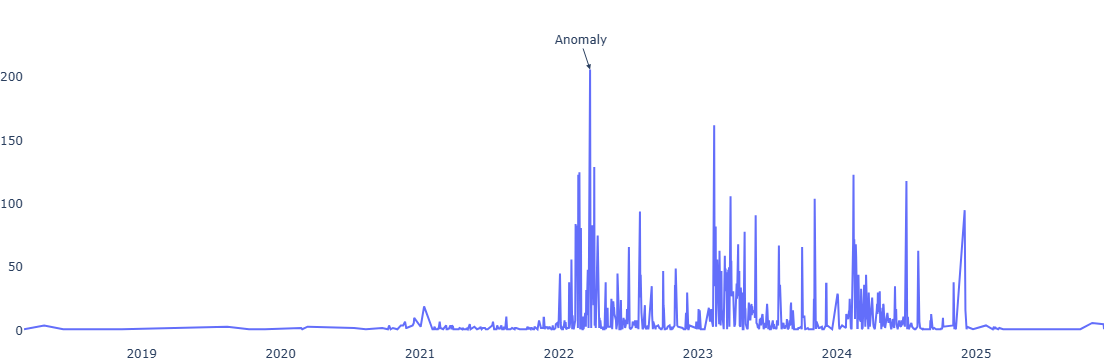

In [108]:
fig3 = generate_plot_timeseries(z,"line","StartDate", "count")
fig3.update_layout(
    xaxis_title=None,
    yaxis_title=None,
    plot_bgcolor="rgba(0,0,0,0)",
    margin=dict(l=0,r=0,t=30,b=0),
    annotations = [dict
        (
            text="Anomaly",
            x=  "2022-03-24",
            y="206",
            arrowhead=2,
            showarrow=True,
            font=dict(size=12),
            bgcolor="white"
            
        )
    ]
)
fig3.show()

In [31]:
#TOP province in terms of flood control projects
top_prov = df.groupby("Province")["ProjectID"].count().reset_index(name="count")
top_prov = top_prov.sort_values(by="count", ascending=False).reset_index(drop=True).head(10)
top_prov

,Province,count
0,BULACAN,668
1,CEBU,414
2,ISABELA,341
3,PANGASINAN,313
4,PAMPANGA,292
5,ALBAY,273
6,LEYTE,262
7,TARLAC,258
8,CAMARINES SUR,252
9,ILOCOS NORTE,224


In [73]:
per_prov = df.groupby("Province").agg(ProjectCounts=("ProjectID","count"),ProjectFunds=("ABC","sum")).reset_index().sort_values(by="ProjectCounts", ascending=False)
per_prov["ProjectFunds"] = per_prov["ProjectFunds"].apply(lambda x: hu.intword(x))
per_prov["Province"] = per_prov["Province"].apply(lambda x: x.title())
per_prov = per_prov.reset_index(drop=True).head(10)
fig2 = px.bar(per_prov, x="ProjectCounts",y="Province", orientation="h",category_orders={"Province": per_prov["Province"].tolist()},
      title="Top 10 Province by Flood Control Projects"
      )

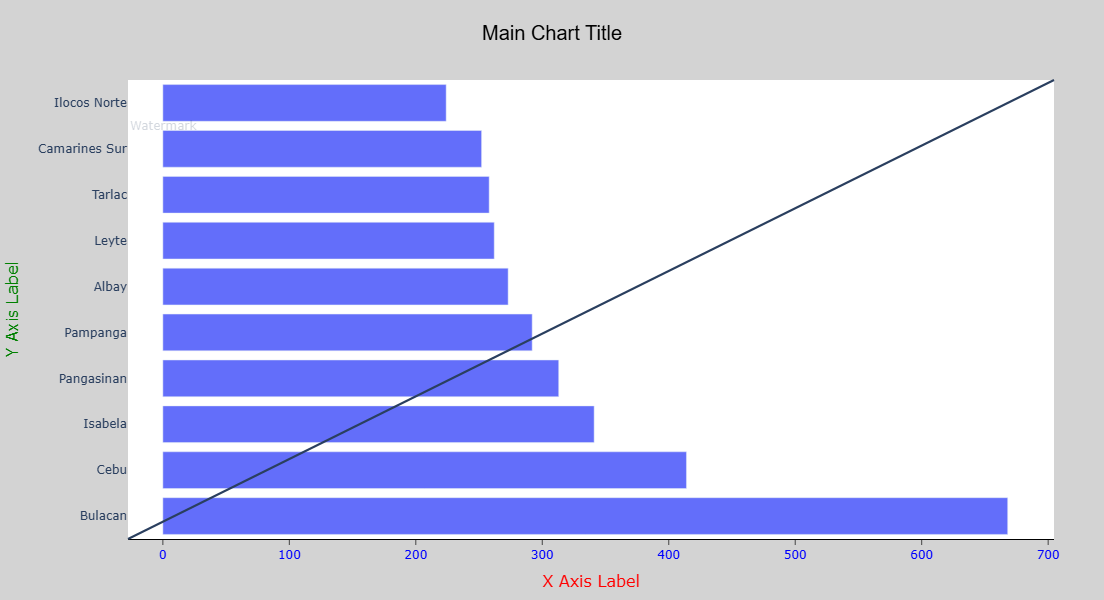

In [60]:
fig.update_layout(
    # Titles
    title="Main Chart Title",
    title_x=0.5,  # center the title
    title_font=dict(size=20, color="black", family="Arial"),

    # Axes
    xaxis_title="X Axis Label",
    yaxis_title="Y Axis Label",
    xaxis=dict(
        showgrid=True,
        zeroline=False,
        showline=True,
        linewidth=1,
        linecolor="black",
        ticks="outside",
        tickfont=dict(size=12, color="blue"),
        title=dict(text="X Axis Label", font=dict(size=16, color="red"))
    ),
    yaxis=dict(
        showgrid=True,
        zeroline=False,
        autorange="reversed",  # useful for barh charts
        tickfont=dict(size=12),
        title=dict(text="Y Axis Label", font=dict(size=16, color="green"))
    ),

    # Legend
    legend=dict(
        title="Legend Title",
        orientation="h",   # horizontal
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),

    # Margins
    margin=dict(l=50, r=50, t=80, b=50),

    # Background
    plot_bgcolor="white",   # inside plotting area
    paper_bgcolor="lightgray",  # whole figure background

    # Size
    height=600,
    width=800,

    # Annotations, shapes, images
    annotations=[dict(text="Watermark", x=0.5, y=0.5, showarrow=False, opacity=0.2)],
    shapes=[dict(type="line", x0=0, x1=1, y0=0, y1=1, xref="paper", yref="paper")],
)
fig.show()

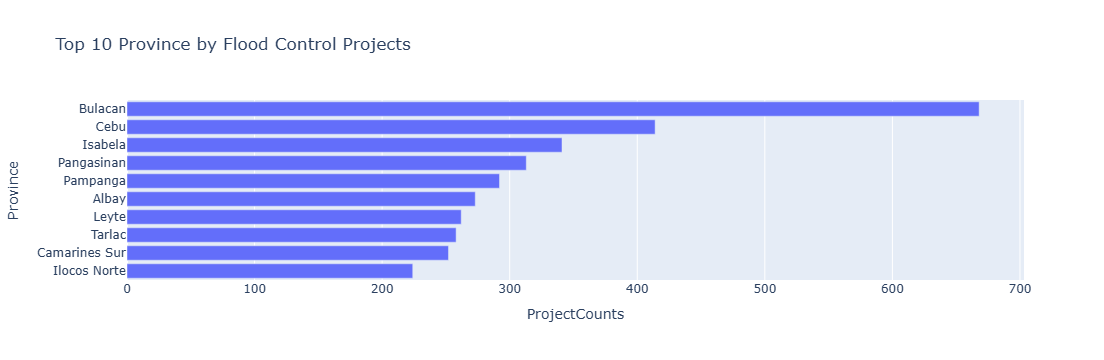

In [74]:
fig2.update_layout(
    annotations=[
        {
            text="Anomaly"
        }
    ]
)

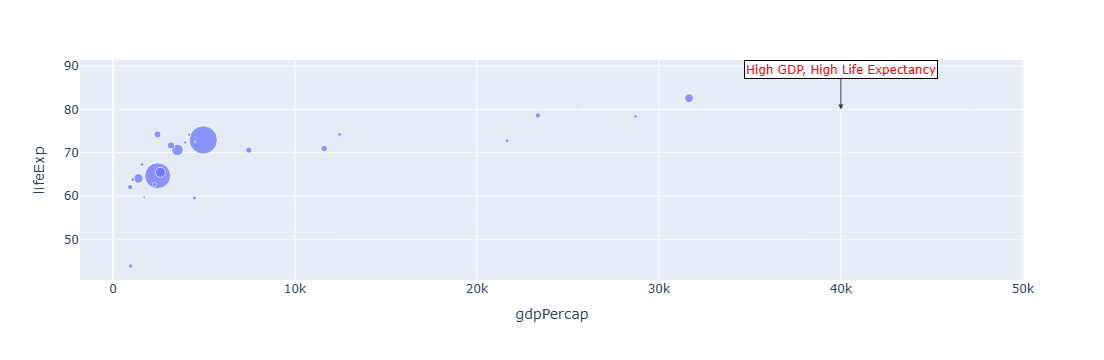

In [61]:
import plotly.express as px

df = px.data.gapminder().query("year == 2007 and continent == 'Asia'")
fig = px.scatter(df, x="gdpPercap", y="lifeExp", size="pop", hover_name="country")

fig.update_layout(
    annotations=[
        dict(
            x=40000, y=80,  # Position in data coordinates
            text="High GDP, High Life Expectancy",
            showarrow=True,
            arrowhead=2,
            ax=0, ay=-40,  # arrow tail shift
            font=dict(size=12, color="red"),
            bgcolor="white",
            bordercolor="black",
            borderwidth=1
        )
    ]
)

fig.show()


In [69]:
df["ABC"]

0       1.796348e+07
1       1.737000e+07
2       1.833500e+07
3       4.900000e+06
4       1.544000e+08
            ...     
9850    3.376590e+07
9851    4.900000e+07
9852    3.430000e+07
9853    7.720000e+07
9854    9.313788e+07
Name: ABC, Length: 9855, dtype: float64

C:\Users\vivobook\AppData\Local\Temp\ipykernel_39296\3144118453.py:3: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



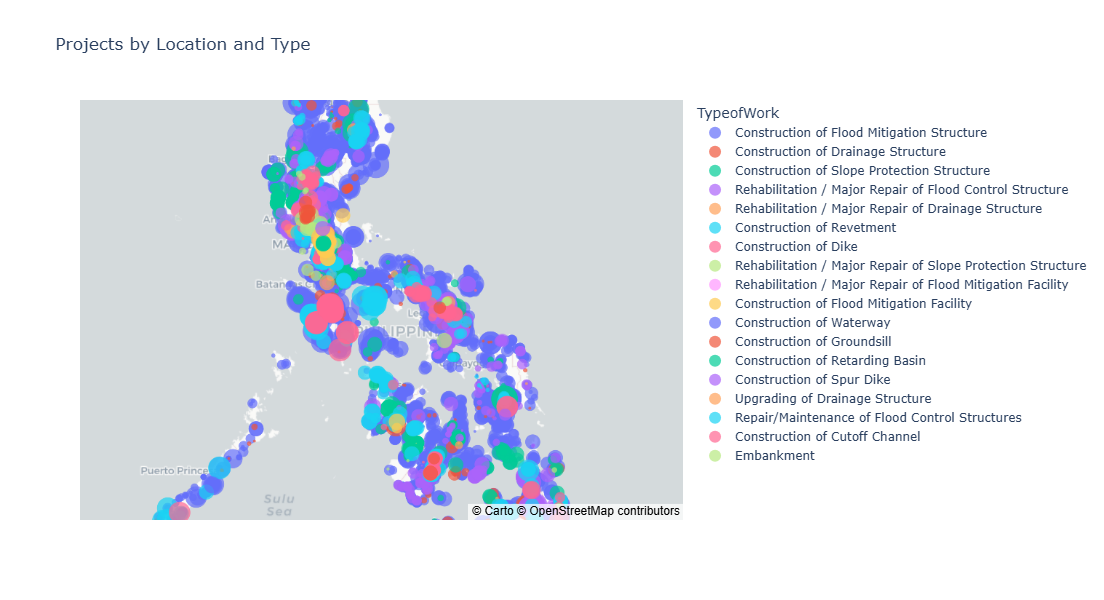

In [72]:
import plotly.express as px

fig = px.scatter_mapbox(
    df,
    lat="Latitude",
    lon="Longitude",
    size="ABC",
    hover_name="ProjectDescription",
    color="TypeofWork",
    zoom=5,
    height=600,
    title="Projects by Location and Type",
    mapbox_style="carto-positron"  # you can also use "open-street-map"
)

fig.show()


In [138]:
discaya= df.loc[df["Contractor"].str.contains("|".join(di),case=False, na=False)].reset_index(drop=True)

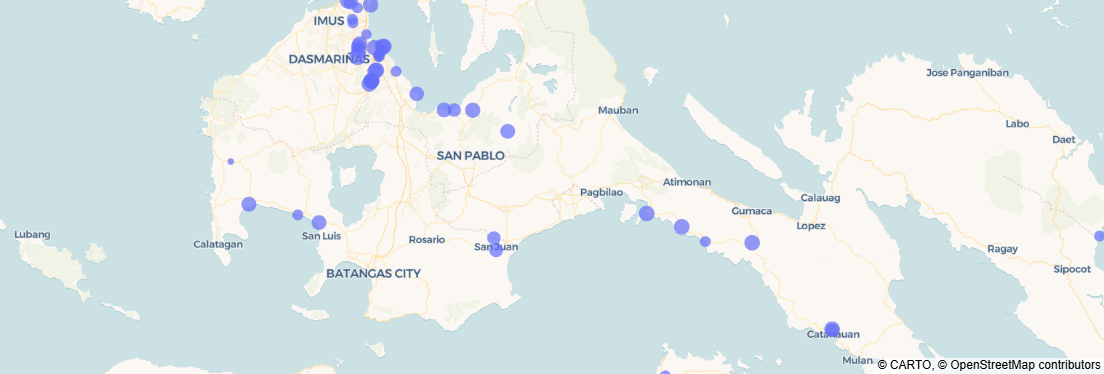

In [145]:

diz = px.scatter_map(
    discaya,
    lat="Latitude",
    lon="Longitude",
    size="ABC",
    hover_data=["TypeofWork","ABC",]
)
diz.update_layout(
    margin=dict(t=0,b=0,r=0,l=0)
)

In [132]:
di = ["alpha", "timothy","gerrard","elite general", "matthew","pacific builders","ypr","amethyst horizon","way maker"]

In [160]:
#discaya projhects largest funding
top_proj = discaya[["Contractor","Province","TypeofWork","Municipality","ABC"]].sort_values(by="ABC",ascending=False).reset_index(drop=True)
top_proj["Cost"] = top_proj["ABC"].apply(lambda x: hu.intword(x))
top_proj.drop("ABC",axis=1,inplace=True)
top_proj.head(20)

,Contractor,Province,TypeofWork,Municipality,Cost
0,ALPHA & OMEGA GEN. CONTRACTOR & DEVELOPMENT CORP.,ORIENTAL MINDORO,Construction of Flood Mitigation Structure,NAUJAN (ORIENTAL MINDORO),289.5 million
1,AMETHYST HORIZON BUILDERS AND GEN. CONTRACTOR ...,OCCIDENTAL MINDORO,Construction of Flood Mitigation Structure,PALUAN (OCCIDENTAL MINDORO),289.5 million
2,GREAT PACIFIC BUILDERS AND GEN. CONTRACTOR INC.,OCCIDENTAL MINDORO,Construction of Flood Mitigation Structure,SABLAYAN (OCCIDENTAL MINDORO),289.5 million
3,YPR GEN. CONTRACTOR AND CONSTRUCTION SUPPLY INC.,ROMBLON,Construction of Flood Mitigation Structure,SAN ANDRES (ROMBLON),289.5 million
4,ST. TIMOTHY CONSTRUCTION CORPORATION,ORIENTAL MINDORO,Construction of Flood Mitigation Structure,NAUJAN (ORIENTAL MINDORO),247.5 million
5,ELITE GENERAL CONTRACTOR AND DEVELOPMENT CORP.,ORIENTAL MINDORO,Construction of Flood Mitigation Structure,NAUJAN (ORIENTAL MINDORO),247.5 million
6,ALPHA & OMEGA GEN. CONTRACTOR & DEVELOPMENT CORP.,OCCIDENTAL MINDORO,Construction of Flood Mitigation Structure,PALUAN (OCCIDENTAL MINDORO),241.2 million
7,GREAT PACIFIC BUILDERS AND GEN. CONTRACTOR INC.,ORIENTAL MINDORO,Construction of Flood Mitigation Structure,NAUJAN (ORIENTAL MINDORO),241.2 million
8,YPR GEN. CONTRACTOR AND CONSTRUCTION SUPPLY INC.,OCCIDENTAL MINDORO,Construction of Revetment,SANTA CRUZ (OCCIDENTAL MINDORO),241.2 million
9,ST. MATTHEW GEN. CONTRACTOR & DEVELOPMENT CORP.,OCCIDENTAL MINDORO,Construction of Revetment,SANTA CRUZ (OCCIDENTAL MINDORO),241.2 million


In [152]:
top_proj

,Province,TypeofWork,Municipality,ABC,Cost
0,ORIENTAL MINDORO,Construction of Flood Mitigation Structure,NAUJAN (ORIENTAL MINDORO),2.895000e+08,289.5 million
1,OCCIDENTAL MINDORO,Construction of Flood Mitigation Structure,PALUAN (OCCIDENTAL MINDORO),2.895000e+08,289.5 million
2,OCCIDENTAL MINDORO,Construction of Flood Mitigation Structure,SABLAYAN (OCCIDENTAL MINDORO),2.895000e+08,289.5 million
3,ROMBLON,Construction of Flood Mitigation Structure,SAN ANDRES (ROMBLON),2.895000e+08,289.5 million
4,ORIENTAL MINDORO,Construction of Flood Mitigation Structure,NAUJAN (ORIENTAL MINDORO),2.475000e+08,247.5 million
...,...,...,...,...,...
429,BULACAN,Construction of Flood Mitigation Structure,ANGAT (BULACAN),1.861971e+07,18.6 million
430,PASIG CITY,Rehabilitation / Major Repair of Flood Control...,CITY OF PASIG (METROPOLITAN MANILA),1.567950e+07,15.7 million
431,BUKIDNON,Construction of Flood Mitigation Structure,CABANGLASAN (BUKIDNON),4.900000e+06,4.9 million
432,PASIG CITY,Rehabilitation / Major Repair of Flood Control...,CITY OF PASIG (METROPOLITAN MANILA),4.409768e+06,4.4 million
